In [ ]:
Track Hospital Visits

Shows when patients are admitted and discharged (admittime, dischtime, deathtime).
Helps count admissions, check lengths of stay, and see mortality rates.
    
Plan Hospital Resources
admission_type and length of stay (LOS_days) help manage beds, staff, and resources.

Predict Patient Outcomes
Data can be used to predict things like the risk of death or readmission.

Analyze Patient Demographics
Includes patient info like age, ethnicity, and marital status.
Useful for studying age distribution and healthcare disparities.

Link to Other Data
Connects to other MIMIC-III tables:
PATIENTS → patient info
ICUSTAYS → ICU stays
DIAGNOSES_ICD → medical diagnoses

Without it, we can’t analyze hospital stays properly.

Columns in dataset: Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')


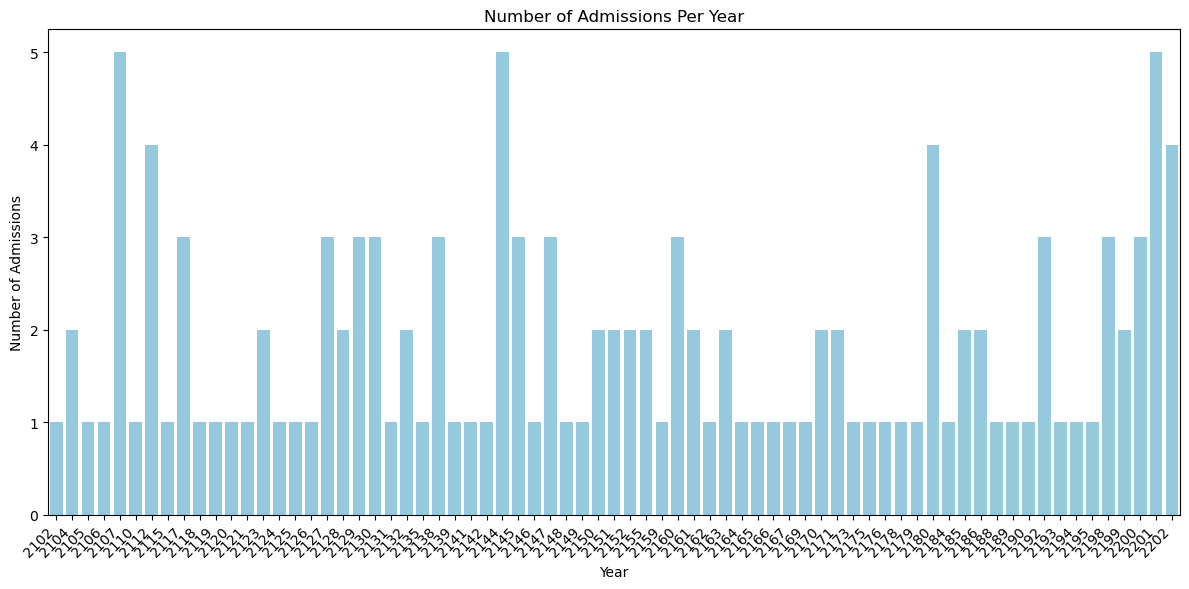

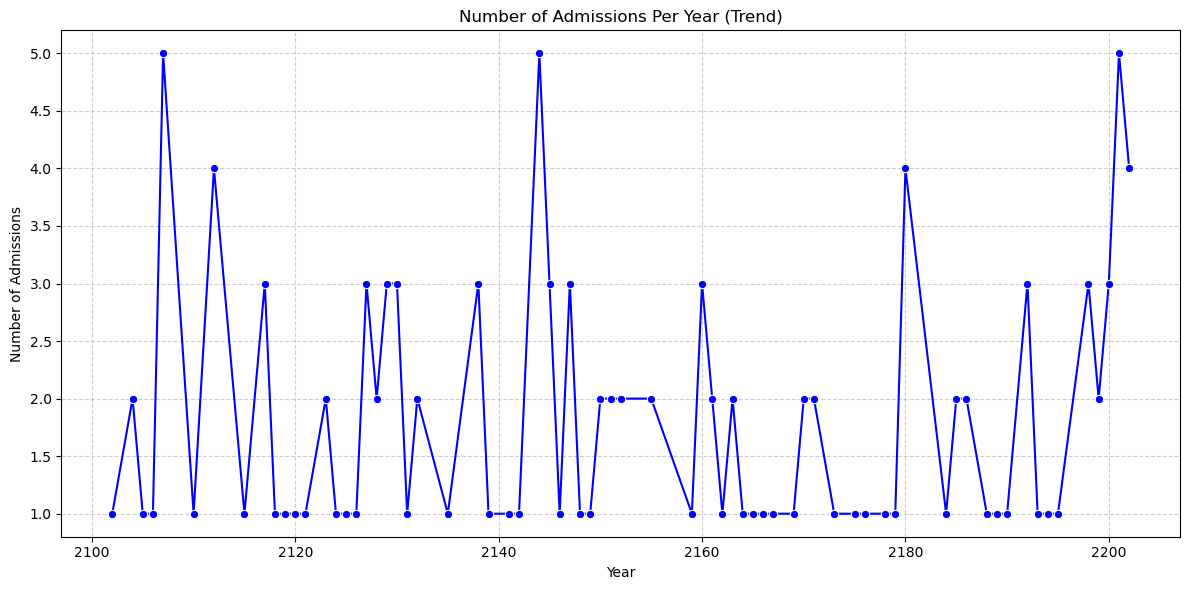

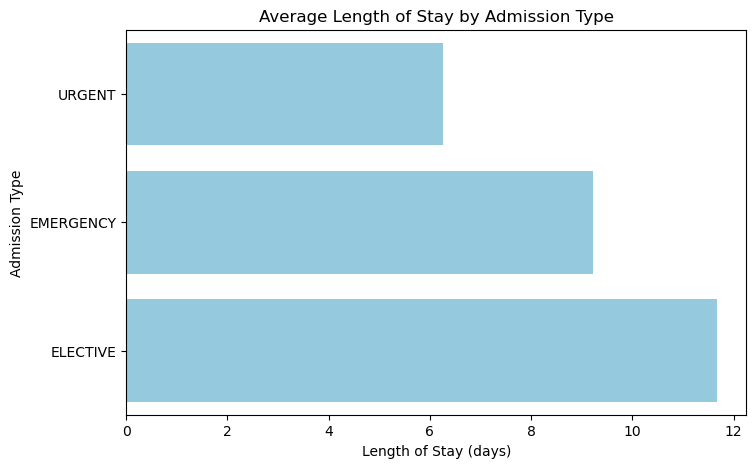

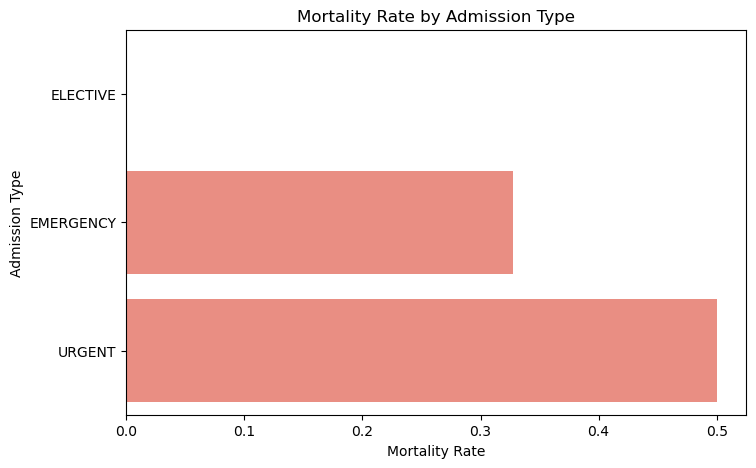

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the MIMIC-III ADMISSIONS dataset
admissions = pd.read_csv("admissions.csv")
print("Columns in dataset:", admissions.columns)

# Convert date columns to datetime
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'], errors='coerce')
# If DOB exists in your dataset, otherwise skip
if 'dob' in admissions.columns:
    admissions['dob'] = pd.to_datetime(admissions['dob'], errors='coerce')

# Extract year of admission
admissions['admit_year'] = admissions['admittime'].dt.year

# ---------- Epidemiological Studies ----------
admissions_per_year = admissions['admit_year'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=admissions_per_year.index, y=admissions_per_year.values, color='skyblue')
plt.title("Number of Admissions Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.xticks(rotation=45, ha="right")   # Rotate labels
plt.tight_layout()
plt.show()

print()

# Alternative: Trend line instead of bar chart
plt.figure(figsize=(12,6))
sns.lineplot(x=admissions_per_year.index, y=admissions_per_year.values, marker="o", color="blue")
plt.title("Number of Admissions Per Year (Trend)")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
print()
# ---------- Resource Allocation ----------
admissions['LOS_days'] = (admissions['dischtime'] - admissions['admittime']).dt.total_seconds() / (24*3600)
los_by_type = admissions.groupby('admission_type')['LOS_days'].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=los_by_type.values, y=los_by_type.index, color='skyblue')
plt.title("Average Length of Stay by Admission Type")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Admission Type")
plt.show()

# ---------- Predictive Modeling ----------
admissions['death_flag'] = admissions['deathtime'].notnull().astype(int)
mortality_by_type = admissions.groupby('admission_type')['death_flag'].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=mortality_by_type.values, y=mortality_by_type.index, color='salmon')
plt.title("Mortality Rate by Admission Type")
plt.xlabel("Mortality Rate")
plt.ylabel("Admission Type")
plt.show()

